In [1]:
!pip install datasets transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == 

In [2]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

# From Hugging Face
from transformers import (
    PreTrainedModel,
    PretrainedConfig,
    DataCollatorForLanguageModeling,
    AutoTokenizer,
)
from datasets import load_dataset

In [13]:
class GPTKerformerConfig(PretrainedConfig):
    model_type = "gpt-kerformer"

    def __init__(
        self,
        vocab_size=50257,
        max_position_embeddings=1024,
        n_embd=256,
        n_layer=4,
        n_head=4,
        hidden_dropout_prob=0.1,
        attention_probs_dropout_prob=0.1,
        kerformer_degree=2,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.vocab_size = vocab_size
        self.max_position_embeddings = max_position_embeddings
        self.n_embd = n_embd
        self.n_layer = n_layer
        self.n_head = n_head
        self.hidden_dropout_prob = hidden_dropout_prob
        self.attention_probs_dropout_prob = attention_probs_dropout_prob
        self.kerformer_degree = kerformer_degree

In [14]:
# -------------------------------------------
# 2. Implement the Kerformer Attention
# -------------------------------------------

class KerformerAttention(nn.Module):
    def __init__(
        self,
        embed_dim,
        num_heads,
        nb_features=64,
        dropout=0.1,
        causal=True,
        degree=2, # polynomial degree
    ):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.nb_features = nb_features
        self.dropout = nn.Dropout(dropout)
        self.head_dim = embed_dim // num_heads

        # Q, K, V linear projections
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.out = nn.Linear(embed_dim, embed_dim)

        self.causal = causal
        self.degree = degree

        # If kernel is purely deterministic, no random features needed
        # self.random_features = ...
        # self.feature_scaling = ...

    def _kernel_projection(self, x: torch.Tensor) -> torch.Tensor:
        """
        Example polynomial feature map, plus row-wise normalization.
        x shape: [batch_size, seq_len, num_heads, head_dim]
        """
        # Simple polynomial expansion: phi(x) = [ 1, sqrt(2)*x, x^2, ... ]
        # This is just an example, could do something more sophisticated or trainable parameterization

        # shape [B, S, H, D]
        # Up to (degree=2): phi(x) = [ x, x^2 ]
        x_sq = x * x
        # Concatenate: shape => [B, S, H, 2*D]
        features = torch.cat([x, x_sq], dim=-1)

        # Row-wise normalization for stability:
        # sum over the "feature" dimension, which is -1
        eps = 1e-6
        denom = torch.sum(features, dim=-1, keepdim=True) + eps
        features = features / denom # normalize row by row

        return features

    def forward(self, hidden_states, attention_mask=None):
        """
        hidden_states: (batch_size, seq_len, embed_dim)
        """
        batch_size, seq_len, _ = hidden_states.size()

        # Project Q, K, V
        q = self.query(hidden_states)  # [B, S, E]
        k = self.key(hidden_states)
        v = self.value(hidden_states)

        # Reshape to multiple heads
        q = q.view(batch_size, seq_len, self.num_heads, self.head_dim)
        k = k.view(batch_size, seq_len, self.num_heads, self.head_dim)
        v = v.view(batch_size, seq_len, self.num_heads, self.head_dim)

        # Kernel feature mapping (deterministic polynomial example)
        q_features = self._kernel_projection(q)  # [B, S, H, ~2*D or something]
        k_features = self._kernel_projection(k)  # [B, S, H, ~2*D]

        # k_features_v: shape [B, H, feature_dim, head_dim]
        # we have to re-check dimension sizes if we used 2*D features, etc.:
        # For example:
        # q_features => [B, S, H, 2D]
        # v          => [B, S, H,   D]
        # => we want to do an einsum that yields [B, H, 2D, D]
        k_features_v = torch.einsum("bshf,bshd->bhfd", k_features, v)

        # Then approximate attention output:
        attn_out = torch.einsum("bshf,bhfd->bshd", q_features, k_features_v)

        # (Optional) scaling
        attn_out = attn_out / math.sqrt(self.head_dim)

        # Merge heads
        attn_out = attn_out.permute(0, 2, 1, 3).contiguous()  # [B, H, S, D]
        attn_out = attn_out.view(batch_size, seq_len, self.embed_dim)

        # Final linear + dropout
        attn_out = self.out(attn_out)
        attn_out = self.dropout(attn_out)

        return attn_out

In [15]:
# -------------------------------------------
# 3. Define a GPT-Kerformer Block
# -------------------------------------------

class GPTKerformerBlock(nn.Module):
    def __init__(self, config: GPTKerformerConfig):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd, eps=1e-5)
        self.attn = KerformerAttention(
            embed_dim=config.n_embd,
            num_heads=config.n_head,
            dropout=config.attention_probs_dropout_prob,
            causal=True,
            degree=config.kerformer_degree,
        )
        self.ln_2 = nn.LayerNorm(config.n_embd, eps=1e-5)
        self.mlp = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.GELU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.hidden_dropout_prob),
        )

    def forward(self, hidden_states, attention_mask=None):
        # Attention
        residual = hidden_states
        hidden_states = self.ln_1(hidden_states)
        hidden_states = self.attn(hidden_states, attention_mask=attention_mask)
        hidden_states = residual + hidden_states

        # MLP
        residual = hidden_states
        hidden_states = self.ln_2(hidden_states)
        hidden_states = self.mlp(hidden_states)
        hidden_states = residual + hidden_states

        return hidden_states

In [16]:
# -------------------------------------------
# 4. Build the Complete GPT-Kerformer Model
# -------------------------------------------

class GPTKerformerModel(PreTrainedModel):
    """
    A GPT-style language model using Kerformer attention.
    """

    config_class = GPTKerformerConfig

    def __init__(self, config: GPTKerformerConfig):
        super().__init__(config)
        self.embed_dim = config.n_embd

        # Embeddings
        self.wte = nn.Embedding(config.vocab_size, config.n_embd)  # token embeddings
        self.wpe = nn.Embedding(config.max_position_embeddings, config.n_embd)  # positional embeddings
        self.drop = nn.Dropout(config.hidden_dropout_prob)

        # Blocks
        self.blocks = nn.ModuleList([GPTKerformerBlock(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd, eps=1e-5)

        # LM head
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        self.post_init()  # from PreTrainedModel

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        labels=None,
        **kwargs
    ):
        """
        input_ids: [batch_size, seq_len]
        attention_mask: [batch_size, seq_len]
        labels: optional, [batch_size, seq_len]
        """
        batch_size, seq_len = input_ids.shape
        device = input_ids.device

        position_ids = torch.arange(0, seq_len, dtype=torch.long, device=device)
        position_ids = position_ids.unsqueeze(0).expand(batch_size, seq_len)

        # Embed
        inputs_embeds = self.wte(input_ids)
        position_embeds = self.wpe(position_ids)
        hidden_states = inputs_embeds + position_embeds
        hidden_states = self.drop(hidden_states)

        # Extended attention mask if we want to incorporate pad tokens, etc.
        extended_mask = None
        if attention_mask is not None:
            extended_mask = attention_mask.unsqueeze(1).unsqueeze(2)  # [B, 1, 1, S]
            extended_mask = (1.0 - extended_mask) * -1e4

        # Pass through blocks
        for block in self.blocks:
            hidden_states = block(hidden_states, attention_mask=extended_mask)

        # Final layer norm
        hidden_states = self.ln_f(hidden_states)

        # LM head
        logits = self.lm_head(hidden_states)

        loss = None
        if labels is not None:
            # Shift for next-token prediction
            shift_logits = logits[:, :-1, :].contiguous()
            shift_labels = labels[:, 1:].contiguous()
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(
                shift_logits.view(-1, shift_logits.size(-1)),
                shift_labels.view(-1)
            )

        return {"loss": loss, "logits": logits}

In [17]:
# -------------------------------------------
# 5. Data Loading: WikiText
# -------------------------------------------

def load_wikitext_dataset(dataset_name="wikitext", dataset_version="wikitext-2-raw-v1"):
    # Returns a DatasetDict with 'train', 'validation', 'test' splits.
    dataset = load_dataset(dataset_name, dataset_version)
    return dataset

# -------------------------------------------
# 6. Tokenizer
# -------------------------------------------

def get_tokenizer(model_name="gpt2"):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    # GPT-2 doesn't have an official pad token
    tokenizer.pad_token = tokenizer.eos_token
    return tokenizer

In [18]:
# -------------------------------------------
# 7. Dataset Preprocessing
# -------------------------------------------

def preprocess_examples(examples, tokenizer, block_size=128):
    """
    Tokenize the text examples, chunk them into blocks of size 'block_size'.
    Returns a dict of tokenized examples (input_ids, etc.).
    """
    text = examples["text"]
    encoding = tokenizer(
        text,
        add_special_tokens=False,
        truncation=True,
        max_length=block_size,
        return_attention_mask=False
    )
    return encoding

def group_texts(examples, block_size=128):
    """
    Group the list of token ids into continuous chunks of size block_size.
    """
    concatenated = []
    for ids in examples["input_ids"]:
        concatenated.extend(ids)
    result = []
    for i in range(0, len(concatenated), block_size):
        chunk = concatenated[i : i + block_size]
        if len(chunk) == block_size:
            result.append(chunk)
    return {"input_ids": result}

In [19]:
# -------------------------------------------
# 8. Training
# -------------------------------------------

# 1) Load dataset
raw_dataset = load_wikitext_dataset()

# 2) Tokenizer
tokenizer = get_tokenizer()

# 3) Preprocess dataset
block_size = 128
def tokenize_function(examples):
    return preprocess_examples(examples, tokenizer, block_size=block_size)
tokenized_dataset = raw_dataset.map(tokenize_function, batched=True, remove_columns=["text"])

# 4) Group texts
def group_function(examples):
    return group_texts(examples, block_size=block_size)
lm_dataset = tokenized_dataset.map(group_function, batched=True)

# 5) Data collator for LM
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

Map:   0%|          | 0/36718 [00:00<?, ? examples/s]

Map:   0%|          | 0/36718 [00:00<?, ? examples/s]

In [20]:
# 6) Create PyTorch Datasets & DataLoaders
train_dataset = lm_dataset["train"]
val_dataset = lm_dataset["validation"]

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=data_collator)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=data_collator)

# 7) Initialize model and optimizer
config = GPTKerformerConfig(
    vocab_size=len(tokenizer),
    max_position_embeddings=1024,
    n_embd=256,
    n_layer=4,
    n_head=4,
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1,
    kerformer_degree=2,
)

model = GPTKerformerModel(config)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# We'll do a simple Adam optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

In [21]:
import os
import psutil
import torch

def print_memory_usage(stage=""):
    # Track GPU memory if available
    if torch.cuda.is_available():
        device = torch.device("cuda")
        gpu_alloc = torch.cuda.memory_allocated(device) / (1024 ** 2)
        gpu_reserved = torch.cuda.memory_reserved(device) / (1024 ** 2)
        print(f"{stage} GPU Memory - Allocated: {gpu_alloc:.2f} MB, Reserved: {gpu_reserved:.2f} MB")
    # Track CPU memory usage for this process
    process = psutil.Process(os.getpid())
    cpu_usage = process.memory_info().rss / (1024 ** 2)
    print(f"{stage} CPU Memory Usage: {cpu_usage:.2f} MB")

In [22]:
num_epochs = 10
loss_vals = []
val_loss_vals = []

for epoch in range(num_epochs):
    print(f"\n--- Epoch {epoch+1} ---")
    print_memory_usage(stage="Start of Epoch")

    model.train()
    total_loss = 0.0
    for step, batch in enumerate(train_dataloader):
        # Move data to device
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device) if "labels" in batch else None
        attention_mask = (input_ids != tokenizer.pad_token_id).long().to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs["loss"]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_val = loss.item()
        total_loss += loss_val

        if (step + 1) % 100 == 0:
            print(f"Epoch {epoch+1} Step {step+1} - Loss: {loss_val:.4f}")
            print_memory_usage(stage=f"After step {step+1}")

    avg_train_loss = total_loss / len(train_dataloader)
    loss_vals.append(avg_train_loss)
    print(f"Epoch {epoch+1} Training Loss: {avg_train_loss:.4f}")
    print_memory_usage(stage="End of Training Epoch")

    # Validation Loop
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device) if "labels" in batch else None
            attention_mask = (input_ids != tokenizer.pad_token_id).long().to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs["loss"]
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_loss_vals.append(avg_val_loss)
    print(f"Epoch {epoch+1} Validation Loss: {avg_val_loss:.4f}")
    print_memory_usage(stage="After Validation Epoch")


--- Epoch 1 ---
Start of Epoch GPU Memory - Allocated: 405.41 MB, Reserved: 752.00 MB
Start of Epoch CPU Memory Usage: 1844.72 MB
Epoch 1 Step 100 - Loss: 8.6702
After step 100 GPU Memory - Allocated: 568.47 MB, Reserved: 978.00 MB
After step 100 CPU Memory Usage: 1844.72 MB
Epoch 1 Step 200 - Loss: 7.6869
After step 200 GPU Memory - Allocated: 568.47 MB, Reserved: 978.00 MB
After step 200 CPU Memory Usage: 1848.74 MB
Epoch 1 Step 300 - Loss: 7.7150
After step 300 GPU Memory - Allocated: 568.47 MB, Reserved: 978.00 MB
After step 300 CPU Memory Usage: 1848.74 MB
Epoch 1 Step 400 - Loss: 7.6095
After step 400 GPU Memory - Allocated: 568.47 MB, Reserved: 978.00 MB
After step 400 CPU Memory Usage: 1848.74 MB
Epoch 1 Step 500 - Loss: 7.8108
After step 500 GPU Memory - Allocated: 568.47 MB, Reserved: 978.00 MB
After step 500 CPU Memory Usage: 1848.74 MB
Epoch 1 Step 600 - Loss: 7.2716
After step 600 GPU Memory - Allocated: 568.47 MB, Reserved: 978.00 MB
After step 600 CPU Memory Usage: 1848

KeyboardInterrupt: 

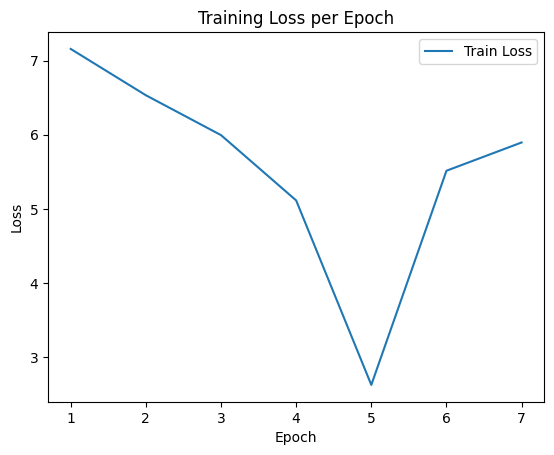

In [23]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(loss_vals) + 1))

# Plot training loss
plt.plot(epochs, loss_vals, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.legend()
plt.show()

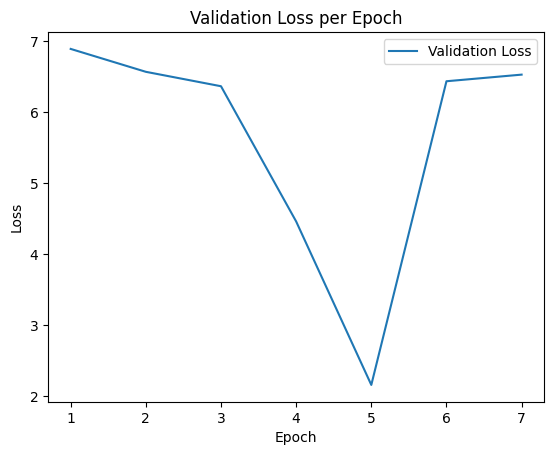

In [24]:
epochs = list(range(1, len(val_loss_vals) + 1))

plt.plot(epochs, val_loss_vals, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss per Epoch")
plt.legend()
plt.show()

In [25]:
test_text = "Artificial intelligence is"
inputs = tokenizer.encode(test_text, return_tensors="pt").to(device)
model.eval()

print_memory_usage(stage="Before Inference")

max_new_tokens = 50
with torch.no_grad():
    for _ in range(max_new_tokens):
        outputs = model(inputs)
        logits = outputs["logits"]
        # Greedy decoding: take the argmax of the last token's logits
        next_token_id = torch.argmax(logits[0, -1, :])
        inputs = torch.cat([inputs, next_token_id.unsqueeze(0).unsqueeze(0)], dim=1)

generated_text = tokenizer.decode(inputs[0])
print(f"\nPrompt: {test_text}")
print(f"Generated text: {generated_text}")

print_memory_usage(stage="After Inference")

Before Inference GPU Memory - Allocated: 518.47 MB, Reserved: 978.00 MB
Before Inference CPU Memory Usage: 1859.33 MB

Prompt: Artificial intelligence is
Generated text: Artificial intelligence is a " , and the first game , and the same , and the first time , and the first broadcast , and the first of the first , and the first time , and the first time , and the first two , and the first time , the
After Inference GPU Memory - Allocated: 482.27 MB, Reserved: 978.00 MB
After Inference CPU Memory Usage: 1860.16 MB


In [26]:
test_text = "Artificial intelligence is"
inputs = tokenizer.encode(test_text, return_tensors="pt").to(device)
model.eval()

print_memory_usage(stage="Before Inference")

max_new_tokens = 1000
with torch.no_grad():
    for _ in range(max_new_tokens):
        outputs = model(inputs)
        logits = outputs["logits"]
        # Greedy decoding: take the argmax of the last token's logits
        next_token_id = torch.argmax(logits[0, -1, :])
        inputs = torch.cat([inputs, next_token_id.unsqueeze(0).unsqueeze(0)], dim=1)

generated_text = tokenizer.decode(inputs[0])
print(f"\nPrompt: {test_text}")
print(f"Generated text: {generated_text}")

print_memory_usage(stage="After Inference")

Before Inference GPU Memory - Allocated: 478.63 MB, Reserved: 978.00 MB
Before Inference CPU Memory Usage: 1860.16 MB

Prompt: Artificial intelligence is
Generated text: Artificial intelligence is a " , and the first game , and the same , and the first time , and the first broadcast , and the first of the first , and the first time , and the first time , and the first two , and the first time , the first season , and the first time , and the first time , and the first , and the first time , and the first time , the first , the first time , the first time , the first , the first time , the first time , the first time , the first time , the first time , the first time , the first time , the first , the first , the first , the first , the first , the first , the first , the first , the first , the first , the first the first , the first the first , the first , the first , the first , the first , the first , the first , the first , the first , the first , the first , the first , the first 

In [ ]:
print(train_dataset)